<a href="https://colab.research.google.com/github/Natural-Language-Processing-YU/M3_Assignment/blob/main/scripts/m3_assignment_part_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part III
Using the previous two tutorials, please answer the following using an encorder-decoder approach and an LSTM compared approach. 

Please create a transformer-based classifier for English name classification into male or female.

There are several datasets for name for male or female classification. In subseuqent iterations, this could be expanded to included more classifications. 

Below is the source from NLTK, which only has male and female available but could be used for the purposes of this assignment. 

```
names = nltk.corpus.names
names.fileids()
['female.txt', 'male.txt']
male_names = names.words('male.txt')
female_names = names.words('female.txt')
[w for w in male_names if w in female_names]
['Abbey', 'Abbie', 'Abby', 'Addie', 'Adrian', 'Adrien', 'Ajay', 'Alex', 'Alexis',
'Alfie', 'Ali', 'Alix', 'Allie', 'Allyn', 'Andie', 'Andrea', 'Andy', 'Angel',
'Angie', 'Ariel', 'Ashley', 'Aubrey', 'Augustine', 'Austin', 'Averil', ...]
```

In [1]:
from typing import List
import pandas as pd

import nltk
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW

from tokenizers import CharBPETokenizer

# Data Preparation:

In [2]:
inputs = nltk.corpus.names
inputs.fileids()
male_names: List[str] = inputs.words('male.txt')
female_names: List[str] = inputs.words('female.txt')

# Model 1: Transformer-based Model (BERT)

In [3]:
from transformers import BertTokenizerFast, BertForSequenceClassification

/Users/hiepdang/katz/natural_language_processing/nlp_assignment4/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Preprocess the data
labels = [0] * len(male_names) + [1] * len(female_names)
inputs = male_names + female_names

# Load pre-trained model and tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

inputs = tokenizer(inputs, truncation=True, padding=True, max_length=128)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test the tokenizer by encoding my name:

In [5]:
tokenizer('hiep dang')

{'input_ids': [101, 7632, 13699, 4907, 2290, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

Create the dataset:

In [6]:
# Dataset
class NameDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.inputs.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [7]:
dataset = NameDataset(inputs, labels)

The first record of the dataset:

In [8]:
dataset[0]

{'input_ids': tensor([  101,  9779, 14503,   102,     0,     0,     0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0]),
 'attention_mask': tensor([1, 1, 1, 1, 0, 0, 0]),
 'labels': tensor(0)}

Split the dataset into train, val, test sets:

In [9]:
train_dataset, val_dataset, test_dataset = random_split(dataset, lengths=[0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(1))

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader =  DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### TRAINING:

In [11]:
optimizer = AdamW(model.parameters(), lr=1e-5)

Training Loss: 0.36728109666450537
Validation Accuracy: 0.8513853904282116
Validation Precision: 0.8775933609958506
Validation Recall: 0.8775933609958506
Validation F1 Score: 0.8775933609958506
End of Epoch 1
-----------
Training Loss: 0.2311578099264871
Validation Accuracy: 0.8551637279596978
Validation Precision: 0.8677354709418837
Validation Recall: 0.8983402489626556
Validation F1 Score: 0.8827726809378186
End of Epoch 2
-----------
Training Loss: 0.1632817968276877
Validation Accuracy: 0.8576826196473551
Validation Precision: 0.8835758835758836
Validation Recall: 0.8817427385892116
Validation F1 Score: 0.8826583592938733
End of Epoch 3
-----------
Training Loss: 0.1149537603618886
Validation Accuracy: 0.8400503778337531
Validation Precision: 0.8721174004192872
Validation Recall: 0.8630705394190872
Validation F1 Score: 0.867570385818561
End of Epoch 4
-----------
Training Loss: 0.0914393299090765
Validation Accuracy: 0.8425692695214105
Validation Precision: 0.8742138364779874
Valid

<Axes: >

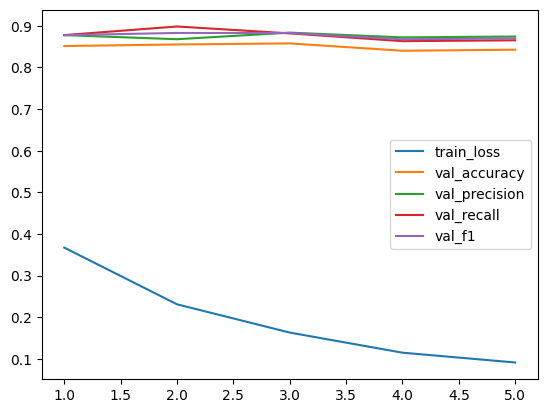

In [12]:
records = {'train_loss': [], 'val_accuracy': [], 'val_precision': [], 'val_recall': [], 'val_f1': []}

epochs = 5

for epoch in range(epochs):

    # TRAINING
    train_loss = []

    for batch in train_dataloader:
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    avg_loss = sum(train_loss) / len(train_loss)
    records['train_loss'].append(avg_loss)
    print(f'Training Loss: {avg_loss}')

    # VALIDATION
    gt_labels = []
    pred_labels = []
    
    with torch.no_grad():
        for batch in val_dataloader:
            outputs = model(**batch)
            _, predicted = torch.max(outputs.logits, dim=1)
            labels = batch['labels']
            gt_labels.extend(labels.tolist())
            pred_labels.extend(predicted.tolist())

    val_accuracy = accuracy_score(y_true=gt_labels, y_pred=pred_labels)
    val_precision = precision_score(y_true=gt_labels, y_pred=pred_labels)
    val_recall = recall_score(y_true=gt_labels, y_pred=pred_labels)
    val_f1 = f1_score(y_true=gt_labels, y_pred=pred_labels)

    records['val_accuracy'].append(val_accuracy)
    records['val_precision'].append(val_precision)
    records['val_recall'].append(val_recall)
    records['val_f1'].append(val_f1)

    print(f'Validation Accuracy: {val_accuracy}')
    print(f'Validation Precision: {val_precision}')
    print(f'Validation Recall: {val_recall}')
    print(f'Validation F1 Score: {val_f1}')
    print(f'End of Epoch {epoch + 1}')
    print(f'-----------')

df = pd.DataFrame(records, index=range(1, epochs + 1, 1))
df.plot()
            

### MODEL EVALUATION:

In [13]:
# EVALUATION
gt_labels = []
pred_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        outputs = model(**batch)
        _, predicted = torch.max(outputs.logits, dim=1)
        labels = batch['labels']
        gt_labels.extend(labels.tolist())
        pred_labels.extend(predicted.tolist())

test_accuracy = accuracy_score(y_true=gt_labels, y_pred=pred_labels)
test_precision = precision_score(y_true=gt_labels, y_pred=pred_labels)
test_recall = recall_score(y_true=gt_labels, y_pred=pred_labels)
test_f1 = f1_score(y_true=gt_labels, y_pred=pred_labels)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test F1 Score: {test_f1}')
print(f'-----------')


Test Accuracy: 0.8639798488664987
Test Precision: 0.8977035490605428
Test Recall: 0.8793456032719836
Test F1 Score: 0.8884297520661157
-----------


# Model 2: LSTM

In [14]:
# Prepare the raw data
labels = [0] * len(male_names) + [1] * len(female_names)
names = male_names + female_names

# Train a CharBPETokenizer on names
tokenizer = CharBPETokenizer()
tokenizer.train_from_iterator(names)

Test the tokenizer by encoding my name:

In [15]:
tokenizer.encode('Hiep Dang').ids

[10, 37, 33, 72, 303, 64]

In [16]:
encoded_names = tokenizer.encode_batch(names)
max_length = max([len(encoding.ids) for encoding in encoded_names])

inputs = []
for encoding in encoded_names:
    inputs.append(encoding.ids + [0] * (max_length - len(encoding.ids)))

First 5 encoded names:

In [17]:
print(inputs[:5])

[[3, 2072, 0, 0, 0, 0], [3, 83, 102, 0, 0, 0], [2518, 0, 0, 0, 0, 0], [1678, 0, 0, 0, 0, 0], [853, 618, 0, 0, 0, 0]]


Create a Dataset:

In [18]:
class NameDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx]).unsqueeze(1).float(), torch.tensor(self.labels[idx]).long()

    def __len__(self):
        return len(self.labels)

Split the dataset into train, val, test sets:

In [19]:
dataset = NameDataset(inputs, labels)

train_dataset, val_dataset, test_dataset = random_split(dataset, lengths=[0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(1))

In [20]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Define the model architecture:

In [21]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_lstm_layers, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        output = self.fc(hidden[-1])
        return output

model = LSTMClassifier(input_dim=1, hidden_dim=512, num_lstm_layers=2, output_dim=2)


### TRAINING:

Define the optimizer:

In [22]:
optimizer = AdamW(model.parameters())

Run the training loop:

Training Loss: 0.32649302991790385
Validation Accuracy: 0.6322418136020151
Validation Precision: 0.6266666666666667
Validation Recall: 0.975103734439834
Validation F1 Score: 0.762987012987013
End of Epoch 1
-----------
Training Loss: 0.32328076361112257
Validation Accuracy: 0.6183879093198993
Validation Precision: 0.6318114874815906
Validation Recall: 0.8900414937759336
Validation F1 Score: 0.7390180878552972
End of Epoch 2
-----------
Training Loss: 0.318952362666178
Validation Accuracy: 0.6272040302267002
Validation Precision: 0.62109375
Validation Recall: 0.9896265560165975
Validation F1 Score: 0.7632
End of Epoch 3
-----------
Training Loss: 0.3189138552950854
Validation Accuracy: 0.6272040302267002
Validation Precision: 0.6375739644970414
Validation Recall: 0.8941908713692946
Validation F1 Score: 0.7443868739205527
End of Epoch 4
-----------
Training Loss: 0.31781995191645984
Validation Accuracy: 0.6360201511335013
Validation Precision: 0.6342141863699583
Validation Recall: 0.9460

<Axes: >

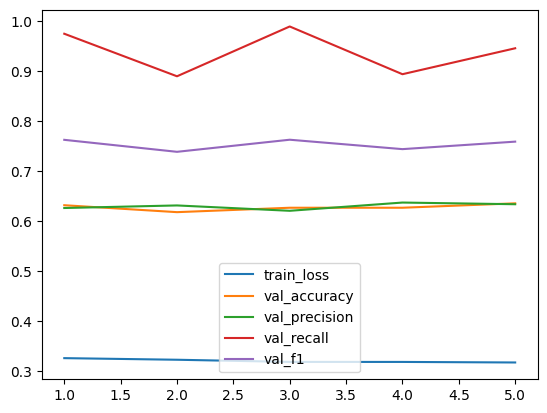

In [23]:
records = {'train_loss': [], 'val_accuracy': [], 'val_precision': [], 'val_recall': [], 'val_f1': []}

epochs = 5


for epoch in range(epochs):

    # TRAINING
    train_loss = []
    for batch in train_dataloader:
        
        optimizer.zero_grad()
        inputs, labels = batch
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels) * 0.5 # does not affect the optimization, just to have better plot
        loss.backward()
        train_loss.append(loss.item())
        optimizer.step()

    avg_loss = sum(train_loss) / len(train_loss)
    records['train_loss'].append(avg_loss)
    print(f'Training Loss: {avg_loss}')


    # VALIDATION
    gt_labels = []
    pred_labels = []
    
    with torch.no_grad():
        for batch in val_dataloader:
            inputs, labels = batch
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            gt_labels.extend(labels.tolist())
            pred_labels.extend(predicted.tolist())

    val_accuracy = accuracy_score(y_true=gt_labels, y_pred=pred_labels)
    val_precision = precision_score(y_true=gt_labels, y_pred=pred_labels)
    val_recall = recall_score(y_true=gt_labels, y_pred=pred_labels)
    val_f1 = f1_score(y_true=gt_labels, y_pred=pred_labels)

    records['val_accuracy'].append(val_accuracy)
    records['val_precision'].append(val_precision)
    records['val_recall'].append(val_recall)
    records['val_f1'].append(val_f1)

    print(f'Validation Accuracy: {val_accuracy}')
    print(f'Validation Precision: {val_precision}')
    print(f'Validation Recall: {val_recall}')
    print(f'Validation F1 Score: {val_f1}')
    print(f'End of Epoch {epoch + 1}')
    print(f'-----------')

df = pd.DataFrame(records, index=range(1, epochs + 1, 1))
df.plot()

### MODEL EVALUATION:

In [24]:
# EVALUATION
gt_labels = []
pred_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        inputs, labels = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)
        gt_labels.extend(labels.tolist())
        pred_labels.extend(predicted.tolist())

val_accuracy = accuracy_score(y_true=gt_labels, y_pred=pred_labels)
val_precision = precision_score(y_true=gt_labels, y_pred=pred_labels)
val_recall = recall_score(y_true=gt_labels, y_pred=pred_labels)
val_f1 = f1_score(y_true=gt_labels, y_pred=pred_labels)

print(f'Test Accuracy: {val_accuracy}')
print(f'Test Precision: {val_precision}')
print(f'Test Recall: {val_recall}')
print(f'Test F1 Score: {val_f1}')
print(f'-----------')

Test Accuracy: 0.6360201511335013
Test Precision: 0.6342141863699583
Test Recall: 0.946058091286307
Test F1 Score: 0.7593671940049959
-----------


# Conclusion:
#### Transformer (BERT) model far outperforms LSTM model

---

# References
1. https://arxiv.org/pdf/2102.03692.pdf
2. https://alvinntnu.github.io/NTNU_ENC2045_LECTURES/exercise/13-attention.html
3. https://towardsdatascience.com/deep-learning-gender-from-name-lstm-recurrent-neural-networks-448d64553044
4. https://www.nltk.org/book/ch02.html#sec-lexical-resources